#### Import modules

In [88]:
import sys
import os
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from dslabs_functions import ts_aggregation_by, series_train_test_split, plot_forecasting_eval, plot_forecasting_series, series_train_test_split
from dslabs_functions import HEIGHT, plot_multiline_chart
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart

#### Load data

In [89]:
data_path = os.path.abspath(os.path.join('..','..', 'data_copy/forecast_gdp_europe.csv'))
if not os.path.exists(data_path):
    print("File not found")
    data_path = os.path.abspath(os.path.join('..','..', 'data/f_e_forecast_gdp_europe.csv'))

TIME_COL: str = "Year"

def load_data(data_path):
    data: DataFrame = read_csv(
        data_path,
        index_col=TIME_COL,
        sep=",",
        decimal=".",
        parse_dates=True,
        infer_datetime_format=True,
    )
    return data

all_data = load_data(data_path)

file_tag = "GDP"
target = "GDP"
TRAIN_SIZE = 0.5



data = all_data[[target]]


File not found


In [90]:
from pandas import DataFrame

def dataframe_train_test_split(data: DataFrame, trn_pct: float = TRAIN_SIZE) -> tuple[DataFrame, DataFrame]:
    trn_size = int(len(data) * trn_pct)
    train = data.iloc[:trn_size]
    test = data.iloc[trn_size:]
    return train, test


#### Preparation

In [98]:
import pandas as pd

def data_preparation(data):
    # Missing value handling
    data: DataFrame = data.dropna(how="any", inplace=False)

    # Scaling
    transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
    data_scaled = DataFrame(transf.transform(data), index=data.index, columns=data.columns)

    # Smoothing
    WIN_SIZE = 25
    data_smooth: DataFrame = data_scaled.rolling(window=WIN_SIZE).mean()
    data_smooth = data_smooth.dropna()

    # Differentiation
    data_diff: DataFrame = data_smooth.diff().dropna()

    # Train/test split
    train, test = dataframe_train_test_split(data_diff)
    print(f"Train size: {len(train)}")
    print(f"Test size: {len(test)}")

    return train, test

    
    
train_target, test_target = data_preparation(data)

train_all, test_all = data_preparation(all_data)


Train size: 16
Test size: 17
Train size: 14
Test size: 14


(16, 17)

In [92]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)


class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

In [93]:
train_all_series = train_all.values.astype("float32")
test_all_series = test_all.values.astype("float32")

In [94]:
input_size = train_all_series.shape[1]
model = DS_LSTM(train_all_series, input_size=input_size, hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

tensor(0.0092, grad_fn=<MseLossBackward0>)


train shape (14, 11)
test shape (14, 11)
seq length=2 hidden_units=25 nr_episodes=0 -279.16156005859375
seq length=2 hidden_units=25 nr_episodes=3 -18.71735382080078
seq length=2 hidden_units=25 nr_episodes=6 -6.555815696716309
seq length=2 hidden_units=25 nr_episodes=9 -21.22188949584961
seq length=2 hidden_units=25 nr_episodes=12 -29.32511329650879
seq length=2 hidden_units=25 nr_episodes=15 -38.0069465637207
seq length=2 hidden_units=25 nr_episodes=18 -45.91864776611328
seq length=2 hidden_units=25 nr_episodes=21 -51.18355941772461
seq length=2 hidden_units=25 nr_episodes=24 -53.52872085571289
seq length=2 hidden_units=25 nr_episodes=27 -55.6263313293457
seq length=2 hidden_units=25 nr_episodes=30 -54.62803649902344
seq length=2 hidden_units=50 nr_episodes=0 -68.20745086669922
seq length=2 hidden_units=50 nr_episodes=3 -44.94842529296875
seq length=2 hidden_units=50 nr_episodes=6 -40.53534698486328
seq length=2 hidden_units=50 nr_episodes=9 -45.22614669799805
seq length=2 hidden_uni

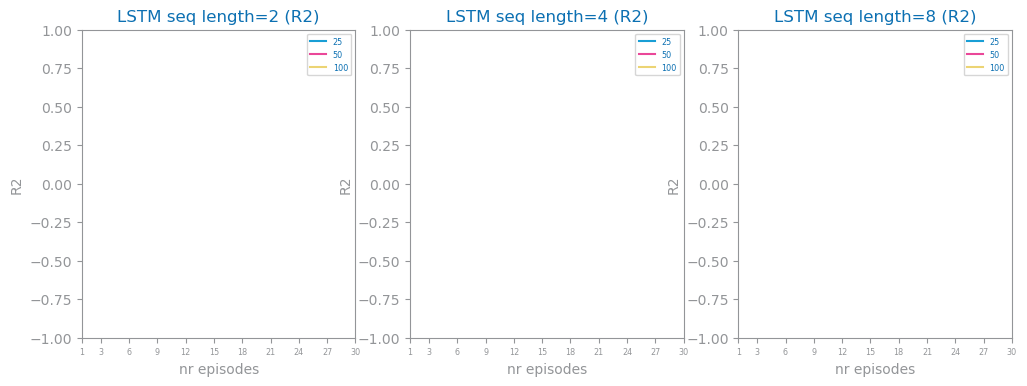

In [95]:
from copy import deepcopy

from matplotlib.pyplot import figure, savefig, subplots


def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    input_size = train.shape[1]
    
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))
    
    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)
        
        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden, input_size=input_size)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    
                    # this is new. 
                    test_formatted = test[:,-1]
                    
                    eval: float = FORECAST_MEASURES[measure](test_formatted[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params

measure: str = "R2"

train = train_all.values.astype("float32")
test = test_all.values.astype("float32")

print("train shape", train.shape)
print("test shape", test.shape)



best_model, best_params = lstm_study(train, test, nr_episodes=30, measure=measure)

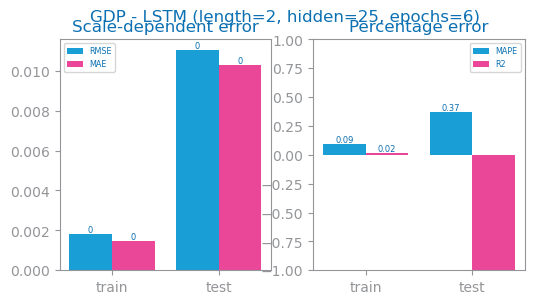

In [96]:
# utils_path = os.path.abspath(os.path.join('..', 'utils'))
# sys.path.append(utils_path)
# from dslabs_functions import plot_forecasting_eval

# params = best_params["params"]
# best_length = params[0]
# trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
# tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

# prd_trn = best_model.predict(trnX)
# prd_tst = best_model.predict(tstX)

# plot_forecasting_eval(
#     train[best_length:],
#     test[best_length:],
#     prd_trn,
#     prd_tst,
#     title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
# )
# savefig(f"images/{file_tag}_lstms_{measure}_eval.png")
utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)
from dslabs_functions import plot_forecasting_eval

train = train_all.values.astype("float32")
test = test_all.values.astype("float32")
params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

# Get the last cloumn of the test sets
# example test_formatted = test[:,-1]

train_eval = train[:,-1]
test_eval = test[:,-1]

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_forecasting_eval(
    train_eval[best_length:],
    test_eval[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"images/{file_tag}_lstms_{measure}_eval.png")

In [97]:
utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from dslabs_functions import plot_forecasting_series

# series = data[[target]]
train, test = train_target, test_target

print((best_length))

print(len(test.index[best_length+1:]))

print(len(prd_tst))
pred_series: Series = Series(prd_tst.numpy().ravel(), index=test.index[best_length:])


2
14
12


ValueError: Length of values (12) does not match length of index (15)

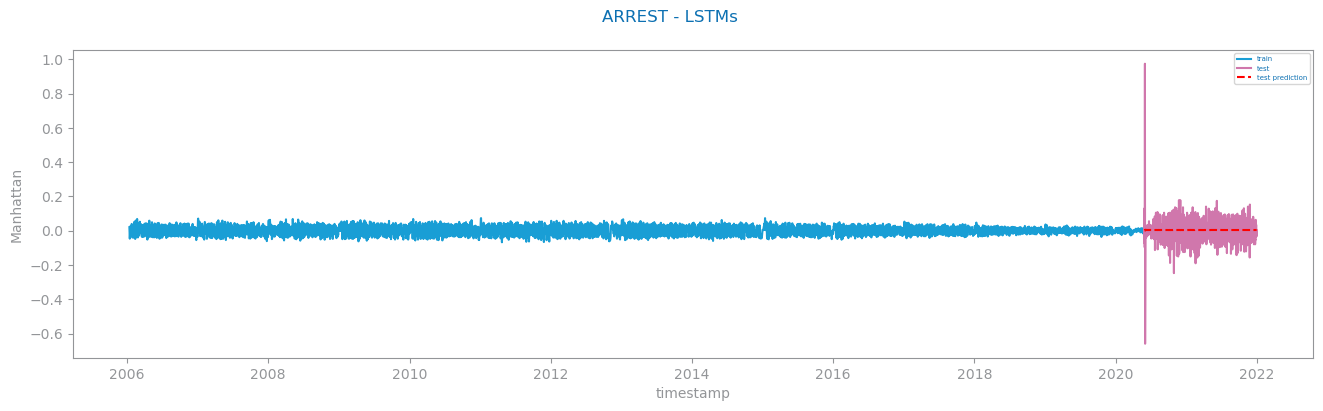

In [130]:

plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - LSTMs ",
    xlabel=TIME_COL,
    ylabel=target,
)
savefig(f"images/{file_tag}_lstms_{measure}_forecast.png")

In [133]:
best_params

{'name': 'LSTM', 'metric': 'R2', 'params': (2, 25, 0)}